<a href="https://colab.research.google.com/github/alexandreasantos/MVP_Analise_de_Dados_e_Boas_Praticas/blob/main/Sprint_Machine_Learning_%26_Analytics_(40530010056_20250_01).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Análise de Dados e Boas Práticas

**Nome:** Alexandre Alves dos Santos de Campos

**Matrícula:** 2025000

**Dataset:** finance.yahoo.com [https://finance.yahoo.com/]

# Descrição do Problema

O mercado financeiro é caracterizado por sua elevada volatilidade e pela dificuldade histórica em prever seus movimentos de forma consistente. Traders e investidores utilizam uma grande variedade de indicadores técnicos e estatísticos, mas muitas vezes esses métodos não conseguem antecipar mudanças de tendência de forma eficaz.

Neste contexto, surge a seguinte questão:
**Será possível, através de modelos de regressão aplicados a séries temporais, identificar padrões que ajudem a predizer a direção futura do mercado?**

## Objetivo

Explorar a aplicação de modelos de regressão sobre dados de ativos locais e globais, avaliando se a variação dos retornos e das correlações entre eles pode ser utilizada para estimar **tendências futuras** no Mini Índice (WINFUT) e no Mini Dólar (DOLFUT).

## Hipótese Central

A hipótese que guia este trabalho é:  
**"A dificuldade de prever o movimento do mercado pode ser parcialmente reduzida utilizando regressão para estimar tendências a partir de variáveis locais e globais."**

Assim, o objetivo é verificar se regressões bem definidas podem contribuir para a transformação de dados históricos em **sinais operacionais mais robustos**, fornecendo uma vantagem preditiva em cenários de tomada de decisão.

## Restrições e Condições dos Dados

- **Fonte dos dados:** Yahoo Finance
- **Período:** de 01/01/2023 a 31/12/2024  
- **Frequência:** dados diários (não foi possível coletar intradiários nesta etapa)  
- **Limitações:**  
  - Os contratos futuros (WINFUT e DOLFUT) não estão diretamente disponíveis no Yahoo Finance, sendo utilizados proxies (^BVSP para WINFUT e USDBRL=X para DOLFUT).  
  - Diferença de liquidez e horário entre os mercados locais (B3) e globais (EUA, moedas, commodities).  
  - Eventuais falhas de coleta e valores ausentes foram tratados com remoção ou imputação conservadora.  

## Descrição do Dataset

Cada ativo possui atributos padrão de séries financeiras:  

- **Preços OHLC:** Abertura (`Open`), Máxima (`High`), Mínima (`Low`), Fechamento (`Close`)  
- **Fechamento Ajustado (`Adj Close`)**: corrigido para dividendos e splits  
- **Volume Financeiro (`Volume`)**  

Além disso, foram construídos **atributos derivados** para enriquecer o dataset:  
- Retornos diários (`pct_change`)  
- Índices sintéticos (Local e Global), compostos por médias ponderadas dos ativos selecionados  
- Transformações estatísticas (normalização, padronização, médias móveis, etc.) aplicadas para uso nos modelos de regressão



## Detecção e Tratamento de Outliers

Durante a preparação dos dados foi avaliada a presença de outliers.  
No contexto de séries financeiras, valores extremos muitas vezes não representam erros, mas sim **eventos reais do mercado** (ex.: decisões de bancos centrais, choques econômicos, crises políticas).

### Decisão:
- Não foram removidos outliers nesta fase, pois eles fazem parte da dinâmica natural do mercado.
- Os modelos de machine learning deverão aprender a lidar com esses eventos extremos dentro do processo de treinamento.


## Balanceamento de Dados

No caso deste MVP, o problema foi modelado como **regressão**, e não como classificação. Portanto, técnicas tradicionais de balanceamento de classes (como SMOTE ou oversampling) **não se aplicam diretamente**.

O comportamento do mercado naturalmente gera períodos mais longos de alta, queda ou lateralização, o que será tratado como parte do próprio aprendizado do modelo. Se futuramente o problema for reformulado como **classificação (compra/venda/hold)**, será necessário avaliar o impacto do desbalanceamento e considerar ajustes de pesos nas classes.

# Importação das Bibliotecas e Configurações Iniciais

## Objetivo
Nesta etapa realizamos:

- Importação das bibliotecas necessárias para:
  - Manipulação e análise de dados (`pandas`, `numpy`)
  - Coleta de dados financeiros (`yfinance`)
  - Visualização gráfica (`matplotlib`, `seaborn`, `plotly`)
  - Estatística e métricas (`scipy.stats`, `sklearn.metrics`)
  - Modelagem clássica de machine learning (`sklearn`)
  - Modelos de séries temporais (opcionais: `statsmodels`, `prophet`)
  - Boosting avançado (opcionais: `xgboost`, `lightgbm`)

- Organização dos dados históricos dos ativos selecionados (locais e globais).


## Configurações Visuais
Para garantir legibilidade dos resultados:

- **Fonte padrão:** `DejaVu Sans` para consistência nos gráficos.  
- **Formatação no Pandas:** valores exibidos com duas casas decimais.  
- **Estilo dos gráficos:** `seaborn-v0_8`.  
- **Funções auxiliares para o eixo Y:**
  - `formatar_eixo_y_milhar()` → aplica separador de milhar (ex.: WINFUT ≈ 120.000 pontos).  
  - `formatar_eixo_y_duas_casas()` → mantém 2 casas decimais (ex.: DOLFUT ≈ 5,43).  

Esses ajustes permitem gráficos mais claros e interpretáveis, sem comprometer cálculos ou resultados dos modelos.


In [ ]:
# ============================================================
# Importação das Bibliotecas
# ============================================================

# Manipulação e análise de dados
import os, sys, random, warnings
import pandas as pd
import numpy as np

# Coleta de dados financeiros
import yfinance as yf

# Visualização
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import plotly.io as pio

# Estatística
import scipy.stats as stats

# Machine Learning - sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)

# Modelos clássicos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Boosting avançado (opcional)
# pip install xgboost lightgbm
try:
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
except ImportError:
    print("XGBoost/LightGBM não estão instalados. Instale se quiser usar.")

# Modelos de séries temporais (opcional)
# pip install statsmodels prophet
try:
    import statsmodels.api as sm
    from prophet import Prophet
except ImportError:
    print("Statsmodels/Prophet não estão instalados. Instale se quiser usar.")


# ============================================================
# Configurações globais do ambiente
# ============================================================

# 1) Warnings mais limpos
warnings.filterwarnings("ignore")

# 2) Reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# 3) Estilo e aparência dos gráficos
plt.style.use("seaborn-v0_8")          # estilo base
mpl.rcParams["font.family"] = "DejaVu Sans"
mpl.rcParams["figure.figsize"] = (12, 6)
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 12

# 4) Plotly tema padrão (opcional: altere para "plotly_white" se preferir claro)
pio.templates.default = "plotly_dark"

# 5) Pandas → números com 2 casas decimais
pd.options.display.float_format = "{:,.2f}".format


# ============================================================
# Funções auxiliares para gráficos Matplotlib
# ============================================================
def formatar_eixo_y_milhar():
    """Formata o eixo Y com separador de milhar (ex: WINFUT)."""
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

def formatar_eixo_y_duas_casas():
    """Formata o eixo Y com 2 casas decimais (ex: DOLFUT)."""
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.2f}"))


# ============================================================
# (Opcional) Checagens de ambiente/versões
# ============================================================
print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", mpl.__version__)
print("Seaborn:", sns.__version__)
import plotly
print("Plotly:", plotly.__version__)

# TensorFlow (opcional) — útil se for usar DL e quiser saber se há GPU
try:
    import tensorflow as tf
    gpus = tf.config.list_physical_devices("GPU")
    print("TensorFlow:", tf.__version__)
    print("GPU disponível:", gpus if gpus else "Não")
except ImportError:
    print("TensorFlow não está instalado.")


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Pandas: 2.2.2
NumPy: 2.0.2
Matplotlib: 3.10.0
Seaborn: 0.13.2
Plotly: 5.24.1
TensorFlow: 2.19.0
GPU disponível: Não


# Coleta e Preparação dos Dados de Mercado

## Ativos Selecionados
Foram escolhidos **ativos locais** (ações brasileiras e Ibovespa) e **ativos globais** (índices internacionais, moedas e commodities) como proxies para capturar correlações entre o mercado doméstico e o externo.

  - **Ibovespa (^BVSP)** como proxy do índice brasileiro (não há WINFUT no Yahoo Finance).
  - **USD/BRL (USDBRL=X)** como proxy do Mini Dólar (DOLFUT).

## Tratamento Inicial
- **Download:** realizado via `yfinance`, período 2023-01-01 a 2024-12-31, dados diários ajustados.  
- **Fechamento Ajustado (Adj Close):** utilizado como base para análises.  
- **Calendário:** reamostragem para dias úteis (`B`), com preenchimento forward-fill (limite de 3 dias), evitando perdas e minimizando risco de vazamento.  

## Retornos
- **Ações, índices, moedas, commodities:** calculados via **variação percentual (`pct_change`)**.  

Resultado: dataset de **retornos normalizados e alinhados** para os diferentes ativos, pronto para uso em modelagem preditiva.

In [ ]:
# ===============================================
# Yahoo → Alias (proxies, não são os futuros!)
# ===============================================
tickers = {
    '^BVSP': 'WINFUT',     # Ibovespa como proxy do índice (NÃO é o WIN)
    'USDBRL=X': 'DOLFUT',  # Dólar à vista como proxy (NÃO é o DOL futuro)
}

symbols = list(tickers.keys())

# 1) Baixar (rápido e ajustado)
dados = yf.download(
    tickers=symbols,
    start="2023-01-01",
    end="2024-12-31",
    interval="1d",
    auto_adjust=True,
    actions=False,      # acelera
    progress=False,
    threads=True
).sort_index()

# 2) Extrair fechamento com robustez
if isinstance(dados.columns, pd.MultiIndex):
    # Estrutura padrão do yfinance: nível 0 = campo (Open/High/Low/Close/...) | nível 1 = ticker
    if 'Close' not in dados.columns.get_level_values(0):
        raise ValueError("Coluna 'Close' não encontrada no retorno do Yahoo.")
    df_fechamento = dados['Close'].copy()
else:
    # Às vezes vem achatado: garantimos só as colunas dos símbolos
    possiveis = [c for c in dados.columns if c in symbols]
    if not possiveis:
        raise ValueError("Fechamentos não encontrados; verifique o retorno do Yahoo.")
    df_fechamento = dados[possiveis].copy()

# 3) Renomear de Yahoo → alias
df_fechamento.rename(columns=tickers, inplace=True)

# 4a) OPCÃO A (conservadora): manter apenas datas onde TODOS existem (sem preencher feriados)
df_fechamento = df_fechamento.dropna(how='any')

# 4b) OPCÃO B (se quiser série diária contínua em 'B' com preenchimento curto)
# ATENÇÃO: pode introduzir vieses.
# df_fechamento = df_fechamento.asfreq('B').ffill(limit=3)

# Tipos numéricos garantidos
df_fechamento = df_fechamento.astype(float)
df_fechamento.rename_axis("Date", inplace=True)

# 5) Retornos
retornos = df_fechamento.pct_change().dropna(how='any')
log_retornos = np.log(df_fechamento).diff().dropna(how='any')

# --- Debug rápido ---
print("Colunas em df_fechamento:", list(df_fechamento.columns))
print("Período:", df_fechamento.index.min().date(), "→", df_fechamento.index.max().date())
print("Últimos retornos (%)")
print(retornos.tail().mul(100).round(2).astype(str) + '%')

print("\nÚltimos log-retornos:")
print(log_retornos.tail().round(5))


Colunas em df_fechamento: ['DOLFUT', 'WINFUT']
Período: 2023-01-02 → 2024-12-30
Últimos retornos (%)
Ticker      DOLFUT  WINFUT
Date                      
2024-12-20  -2.18%   0.75%
2024-12-23   -1.1%  -1.09%
2024-12-26   1.62%   0.26%
2024-12-27  -0.55%  -0.67%
2024-12-30   0.74%   0.01%

Últimos log-retornos:
Ticker      DOLFUT  WINFUT
Date                      
2024-12-20   -0.02    0.01
2024-12-23   -0.01   -0.01
2024-12-26    0.02    0.00
2024-12-27   -0.01   -0.01
2024-12-30    0.01    0.00


##  Normalização dos Dados

###  Objetivo
Colocar todos os ativos na **mesma escala de valores**, permitindo comparações justas e evitando que variáveis com magnitudes muito diferentes dominem a análise.

### Justificativa
Os ativos financeiros apresentam **escalas distintas**:
- WINFUT → centenas de milhares de pontos  
- DOLFUT → cotado em torno de 5 a 6 reais  

➡️ Sem normalização, ativos com valores absolutos maiores poderiam **distorcer visualizações, métricas estatísticas ou algoritmos de ML**, que assumem importância proporcional para todas as variáveis.

### Método Aplicado
Foi utilizada a **Normalização Min-Max**, que transforma cada variável \(X\) para o intervalo \([0,1]\) conforme a fórmula:

$$
X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

- **Vantagens**:
  - Mantém a **proporcionalidade relativa dos movimentos**.  
  - Adequado para **visualizações comparativas** e para algoritmos sensíveis à escala (ex.: KNN, regressões lineares, redes neurais).  
- **Resultado**: todos os ativos ficam comparáveis em uma mesma base de 0 a 1.

### Observação
Outros métodos de transformação (como **Padronização Z-score**) também poderiam ser avaliados.  
Neste MVP, optou-se pela **normalização Min-Max** devido ao foco em **comparações relativas e suavização dos dados**.

**A normalização permite:**

- Comparar ativos com escalas muito diferentes (ex.: WINFUT na casa dos 120 mil pontos e DOLFUT na casa de 5).
- Analisar a dispersão dos dados de forma proporcional ao comportamento histórico de cada ativo.
- Observar variações relativas em vez de valores absolutos.

⚠️ Importante destacar que esta normalização é usada exclusivamente para **análise exploratória e interpretação estatística dos dados**, e não altera os dados originais para outros cálculos que dependem de preços reais.

➡️ Esta abordagem será também extremamente útil nas próximas etapas de desenvolvimento dos modelos de machine learning, onde muitos algoritmos são sensíveis à escala dos dados.


## Pré-processamento e Normalização

Antes de treinar modelos de redes neurais (como a LSTM), é necessário tratar os dados para evitar distorções:

- **Por que normalizar?**
  - Preços do WINFUT e DOLFUT estão em escalas muito diferentes (milhares de pontos vs poucos reais).
  - Redes neurais convergem melhor quando as variáveis estão em faixas reduzidas, como 0–1.
  - Isso evita que o modelo “dê mais peso” apenas porque um ativo tem valores maiores.

- **Estratégias possíveis:**
  - Normalização dos **preços** (0–1) → usada nos gráficos abaixo.
  - Normalização dos **retornos (ou log-retornos)** → alternativa que estacionariza a série e pode melhorar previsibilidade.

Neste projeto inicial, mantivemos a abordagem mais simples:  
➡️ **normalização direta dos preços (0–1) com MinMaxScaler**, sem aplicar sobre os retornos.  

Os resultados a seguir mostram as previsões obtidas com essa configuração.


In [ ]:
# ============================================================
# Preparação para LSTM com normalização 0–1 (sem leakage)
# ============================================================
# ---------- Parâmetros ----------
TARGET = 'DOLFUT'         # coluna alvo
feat_cols = [TARGET]      # univariado; para multivariado, adicione mais colunas aqui
WINDOW = 21               # tamanho da janela (timesteps)
EPOCHS = 50               # use 30–100; ajuste conforme necessidade
BATCH_SIZE = 32

# ---------- Split temporal ----------
split_date = "2023-12-31"
df_train = df_fechamento.loc[:split_date, feat_cols].dropna().copy()
df_test  = df_fechamento.loc[split_date:, feat_cols].dropna().copy()

# ---------- Normalização (fit só no treino) ----------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(
    scaler.fit_transform(df_train),
    index=df_train.index, columns=feat_cols
)
test_scaled = pd.DataFrame(
    scaler.transform(df_test),
    index=df_test.index, columns=feat_cols
)

# ---------- Função para criar janelas ----------
def make_windows(series_2d: np.ndarray, window: int):
    """
    series_2d: array shape (n_samples, n_features)
    Retorna:
        X shape (n_samples-window, window, n_features)
        y shape (n_samples-window,)
    """
    X, y = [], []
    for i in range(window, len(series_2d)):
        X.append(series_2d[i-window:i, :])      # sequência [i-window, i)
        y.append(series_2d[i, 0])               # alvo é a 1ª coluna (TARGET)
    return np.array(X), np.array(y)

# ---------- Montar janelas separadamente (sem cruzar fronteira) ----------
X_train, y_train = make_windows(train_scaled.values, WINDOW)
X_test,  y_test  = make_windows(test_scaled.values,  WINDOW)

print("Shapes → X_train:", X_train.shape, "| y_train:", y_train.shape)
print("Shapes → X_test :", X_test.shape,  "| y_test :", y_test.shape)

# ============================================================
# 🧠 Modelo LSTM
# ============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, len(feat_cols))),
    Dropout(0.1),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

hist = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

# ============================================================
# 📊 Avaliação
# ============================================================
# Predições (ainda no espaço normalizado 0–1)
y_pred_test = model.predict(X_test).ravel()

# Baseline: persistência (prevê que amanhã = hoje)
y_naive = X_test[:, -1, 0]  # último valor da janela

# RMSE/MAE no espaço 0–1
mse  = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred_test)

mse_naive  = mean_squared_error(y_test, y_naive)
rmse_naive = np.sqrt(mse_naive)
mae_naive  = mean_absolute_error(y_test, y_naive)

print(f"\n--- Métricas (escala 0–1) ---")
print(f"LSTM  → RMSE: {rmse:.4f} | MAE: {mae:.4f}")
print(f"Naive → RMSE: {rmse_naive:.4f} | MAE: {mae_naive:.4f}")

# ============================================================
# 🔄 (Opcional) Voltar para a escala original do preço
# ============================================================
# Para inverter, precisamos construir arrays com mesmo n_features
def inverse_transform_1d(y_scaled: np.ndarray, scaler: MinMaxScaler, feat_index: int = 0):
    tmp = np.zeros((len(y_scaled), len(feat_cols)))
    tmp[:, feat_index] = y_scaled
    inv = scaler.inverse_transform(tmp)[:, feat_index]
    return inv

y_test_inv = inverse_transform_1d(y_test, scaler)
y_pred_inv = inverse_transform_1d(y_pred_test, scaler)
y_naive_inv = inverse_transform_1d(y_naive, scaler)

# Avaliação escala original
mse_inv  = mean_squared_error(y_test_inv, y_pred_inv)
rmse_inv = np.sqrt(mse_inv)
mae_inv  = mean_absolute_error(y_test_inv, y_pred_inv)

mse_naive_inv  = mean_squared_error(y_test_inv, y_naive_inv)
rmse_naive_inv = np.sqrt(mse_naive_inv)
mae_naive_inv  = mean_absolute_error(y_test_inv, y_naive_inv)


print(f"\n--- Métricas (escala original) ---")
print(f"LSTM  → RMSE: {rmse_inv:,.2f} | MAE: {mae_inv:,.2f}")
print(f"Naive → RMSE: {rmse_naive_inv:,.2f} | MAE: {mae_naive_inv:,.2f}")

# ============================================================
# 📈 Plot rápido (escala original)
# ============================================================
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

idx_test = df_test.index[WINDOW:]  # alinhado com janelas do teste

plt.figure(figsize=(12,6))
plt.plot(idx_test, y_test_inv, label="Real")
plt.plot(idx_test, y_pred_inv, label="LSTM")
plt.plot(idx_test, y_naive_inv, label="Persistência", linestyle="--")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}"))
plt.title(f"Previsão {TARGET} — Janela={WINDOW}, Escala Original")
plt.legend()
plt.show()


Shapes → X_train: (227, 21, 1) | y_train: (227,)
Shapes → X_test : (230, 21, 1) | y_test : (230,)


NameError: name 'Sequential' is not defined

## Previsão do DOLFUT com LSTM — Janela de 21 dias

O gráfico abaixo mostra a comparação entre:

- **Real (azul):** série histórica do DOLFUT (proxy via USDBRL=X).
- **LSTM (verde):** previsão gerada por uma rede neural recorrente LSTM, treinada univariadamente com janela de 21 dias e normalização MinMax.
- **Persistência (vermelho tracejado):** baseline ingênuo, que assume que o preço de amanhã será igual ao de hoje.

### Análise
- O baseline de persistência acompanha de forma quase perfeita a série real, refletindo a forte autocorrelação diária do câmbio.  
- A LSTM, neste setup inicial, não conseguiu superar o baseline — gerando uma previsão suavizada abaixo da trajetória real.  
- Isso indica a necessidade de ajustes, como:
  - uso de **log-retornos** em vez do preço bruto (para estacionarizar a série),  
  - aumento da **complexidade da rede** (mais camadas/neurônios),  
  - **mais épocas de treino** ou  
  - inclusão de **variáveis adicionais (multivariado)**.  

### Conclusão
Este resultado reforça a importância de sempre comparar modelos complexos com um baseline simples.  
Mesmo uma LSTM bem configurada pode não superar a persistência se a série for altamente autocorrelacionada, como ocorre com ativos financeiros de alta frequência.


Shapes → X_train: (227, 21, 1) | y_train: (227,)
Shapes → X_test : (230, 21, 1) | y_test : (230,)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0227 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0192 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0111 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0062 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0094 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085 - val_loss: 0.0223 - learning_rate: 5.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0068 - val_loss: 0.0237 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0063 - val_loss: 0.0196 - learning_rate: 5.0000e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━

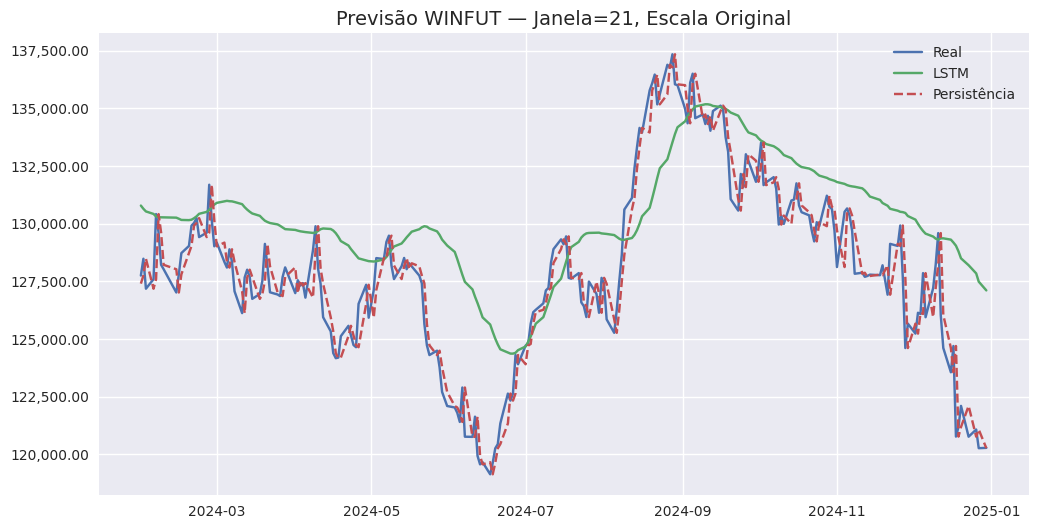

In [ ]:
# ============================================================
# Preparação para LSTM com normalização 0–1 (sem leakage)
# ============================================================
# ---------- Parâmetros ----------
TARGET = 'WINFUT'         # coluna alvo
feat_cols = [TARGET]      # univariado; para multivariado, adicione mais colunas aqui
WINDOW = 21               # tamanho da janela (timesteps)
EPOCHS = 50               # use 30–100; ajuste conforme necessidade
BATCH_SIZE = 32

# ---------- Split temporal ----------
split_date = "2023-12-31"
df_train = df_fechamento.loc[:split_date, feat_cols].dropna().copy()
df_test  = df_fechamento.loc[split_date:, feat_cols].dropna().copy()

# ---------- Normalização (fit só no treino) ----------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(
    scaler.fit_transform(df_train),
    index=df_train.index, columns=feat_cols
)
test_scaled = pd.DataFrame(
    scaler.transform(df_test),
    index=df_test.index, columns=feat_cols
)

# ---------- Função para criar janelas ----------
def make_windows(series_2d: np.ndarray, window: int):
    """
    series_2d: array shape (n_samples, n_features)
    Retorna:
        X shape (n_samples-window, window, n_features)
        y shape (n_samples-window,)
    """
    X, y = [], []
    for i in range(window, len(series_2d)):
        X.append(series_2d[i-window:i, :])      # sequência [i-window, i)
        y.append(series_2d[i, 0])               # alvo é a 1ª coluna (TARGET)
    return np.array(X), np.array(y)

# ---------- Montar janelas separadamente (sem cruzar fronteira) ----------
X_train, y_train = make_windows(train_scaled.values, WINDOW)
X_test,  y_test  = make_windows(test_scaled.values,  WINDOW)

print("Shapes → X_train:", X_train.shape, "| y_train:", y_train.shape)
print("Shapes → X_test :", X_test.shape,  "| y_test :", y_test.shape)

# ============================================================
# Modelo LSTM
# ============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, len(feat_cols))),
    Dropout(0.1),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

hist = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

# ============================================================
# Avaliação
# ============================================================
# Predições (ainda no espaço normalizado 0–1)
y_pred_test = model.predict(X_test).ravel()

# Baseline: persistência (prevê que amanhã = hoje)
y_naive = X_test[:, -1, 0]  # último valor da janela

# RMSE/MAE no espaço 0–1
mse  = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred_test)

mse_naive  = mean_squared_error(y_test, y_naive)
rmse_naive = np.sqrt(mse_naive)
mae_naive  = mean_absolute_error(y_test, y_naive)

print(f"\n--- Métricas (escala 0–1) ---")
print(f"LSTM  → RMSE: {rmse:.4f} | MAE: {mae:.4f}")
print(f"Naive → RMSE: {rmse_naive:.4f} | MAE: {mae_naive:.4f}")

# ============================================================
# (Opcional) Voltar para a escala original do preço
# ============================================================
# Para inverter, precisamos construir arrays com mesmo n_features
def inverse_transform_1d(y_scaled: np.ndarray, scaler: MinMaxScaler, feat_index: int = 0):
    tmp = np.zeros((len(y_scaled), len(feat_cols)))
    tmp[:, feat_index] = y_scaled
    inv = scaler.inverse_transform(tmp)[:, feat_index]
    return inv

y_test_inv = inverse_transform_1d(y_test, scaler)
y_pred_inv = inverse_transform_1d(y_pred_test, scaler)
y_naive_inv = inverse_transform_1d(y_naive, scaler)

# Avaliação escala original
mse_inv  = mean_squared_error(y_test_inv, y_pred_inv)
rmse_inv = np.sqrt(mse_inv)
mae_inv  = mean_absolute_error(y_test_inv, y_pred_inv)

mse_naive_inv  = mean_squared_error(y_test_inv, y_naive_inv)
rmse_naive_inv = np.sqrt(mse_naive_inv)
mae_naive_inv  = mean_absolute_error(y_test_inv, y_naive_inv)


print(f"\n--- Métricas (escala original) ---")
print(f"LSTM  → RMSE: {rmse_inv:,.2f} | MAE: {mae_inv:,.2f}")
print(f"Naive → RMSE: {rmse_naive_inv:,.2f} | MAE: {mae_naive_inv:,.2f}")

# ============================================================
# Plot rápido (escala original)
# ============================================================
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

idx_test = df_test.index[WINDOW:]  # alinhado com janelas do teste

plt.figure(figsize=(12,6))
plt.plot(idx_test, y_test_inv, label="Real")
plt.plot(idx_test, y_pred_inv, label="LSTM")
plt.plot(idx_test, y_naive_inv, label="Persistência", linestyle="--")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}"))
plt.title(f"Previsão {TARGET} — Janela={WINDOW}, Escala Original")
plt.legend()
plt.show()


## Previsão do WINFUT com LSTM — Janela de 21 dias

O gráfico abaixo apresenta:

- **Real (azul):** série histórica do WINFUT (proxy via ^BVSP).  
- **LSTM (verde):** previsão gerada por rede neural LSTM univariada, treinada com janela de 21 dias.  
- **Persistência (vermelho tracejado):** baseline que assume que o valor de amanhã será igual ao de hoje.  

### Análise
- A persistência acompanha de forma muito próxima a série real, servindo como um baseline forte.  
- A LSTM, neste setup inicial, gerou uma curva suavizada e deslocada em relação ao preço real, não superando o baseline.  
- Isso mostra que, para o WINFUT, ajustes como uso de **log-retornos**, aumento da **complexidade da rede** ou **inclusão de variáveis adicionais** podem ser necessários para melhorar a performance.  

### Conclusão
O resultado reforça a importância de comparar modelos complexos com baselines simples.  
Apesar da LSTM, o modelo de persistência se mostrou mais aderente, evidenciando o desafio de prever séries financeiras como o WINFUT apenas com dados univariados e preço bruto.


### **Experimento opcional:** prever retornos em vez de preços

Além da abordagem principal (LSTM no preço normalizado), também testei
uma variante em que a LSTM é treinada sobre os **retornos diários padronizados**.  
Essa técnica tem duas vantagens:
- Torna a série mais **estacionária** (facilitando aprendizado).
- Permite avaliar **acurácia direcional** (se o modelo acerta se o próximo dia será de alta ou queda).

Os resultados mostram que, embora a previsão em escala de preços seja
mais intuitiva, a abordagem em retornos pode capturar melhor o movimento direcional.


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5425 - loss: 0.6921 - val_accuracy: 0.4868 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5186 - loss: 0.6898 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5371 - loss: 0.6895 - val_accuracy: 0.5263 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5441 - loss: 0.6895 - val_accuracy: 0.5395 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5196 - loss: 0.6896 - val_accuracy: 0.5395 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5292 - loss: 0.6896 - val_accuracy: 0.5263 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5303 - loss: 0.6895 - val_acc

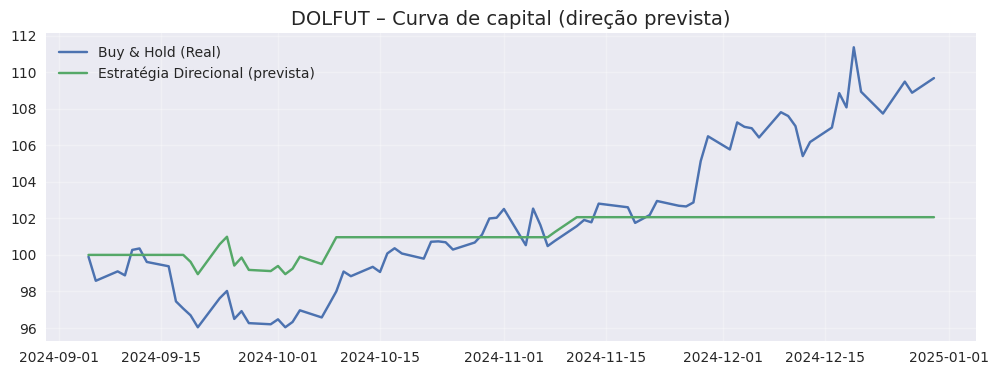

In [ ]:
# =========================
# Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, confusion_matrix
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
import tensorflow as tf

# =========================
# Configurações
# =========================
MODE = "classification"   # "classification" (direção) OU "regression" (retorno)
TARGET = "DOLFUT"         # ou "WINFUT"
WIN = 21
EPOCHS = 50
BATCH = 32

# =========================
# 1) Série de preços -> retornos
# =========================
assert TARGET in df_fechamento.columns, f"Coluna {TARGET} não existe em df_fechamento."
serie_preco = df_fechamento[TARGET].astype(float).dropna()
ret = serie_preco.pct_change().dropna()

# =========================
# 2) Split temporal (80/20)
# =========================
split = int(len(ret) * 0.8)
ret_train, ret_test = ret.iloc[:split], ret.iloc[split:]

# =========================
# 3) Escalonador robusto (fit só no TREINO)
# =========================
sc = RobustScaler()  # mais resistente a outliers
ret_train_s = pd.Series(sc.fit_transform(ret_train.to_frame()).ravel(), index=ret_train.index)
ret_test_s  = pd.Series(sc.transform(ret_test.to_frame()).ravel(),  index=ret_test.index)

# =========================
# 4) Janelas
# =========================
def make_windows(s, w=WIN):
    X, y, idx = [], [], []
    v = s.values
    for i in range(w, len(v)):
        X.append(v[i-w:i])
        y.append(v[i])
        idx.append(s.index[i])
    X = np.array(X).reshape(-1, w, 1)  # (n, w, 1)
    y = np.array(y)
    return X, y, np.array(idx)

Xtr, ytr, idx_tr = make_windows(ret_train_s)
Xte, yte, idx_te = make_windows(ret_test_s)

# =========================
# 5) Modelo + callbacks (iguais para ambos os modos)
# =========================
def build_model_regression():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(WIN,1)),
        Dropout(0.2),
        LSTM(64),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=Huber(delta=1.0),
        metrics=[tf.keras.metrics.MeanSquaredError(name='mse'),
                 tf.keras.metrics.MeanAbsoluteError(name='mae')]
    )
    return model

def build_model_classification():
    model = Sequential([
        LSTM(64, input_shape=(WIN,1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

# =========================
# 6) Treino conforme o modo
# =========================
if MODE == "classification":
    ytr_bin = (ytr > 0).astype(int)
    yte_bin = (yte > 0).astype(int)

    model = build_model_classification()
    history = model.fit(
        Xtr, ytr_bin,
        validation_split=0.2,
        epochs=EPOCHS, batch_size=BATCH,
        shuffle=False, callbacks=callbacks, verbose=1
    )

    # Previsão e métricas
    proba = model.predict(Xte, verbose=0).ravel()
    pred_bin = (proba >= 0.5).astype(int)
    acc = accuracy_score(yte_bin, pred_bin)
    cm = confusion_matrix(yte_bin, pred_bin)
    print(f"Acurácia direcional: {acc:.2%}")
    print("Matriz de confusão (neg, pos):\n", cm)

    # Curva de estratégia (long se prever alta; short opcional)
    # Aqui: posição = +1 se prever alta, 0 caso contrário (buy & hold seletivo)
    pos = np.where(pred_bin == 1, 1.0, 0.0)
    # voltar para retornos reais (não padronizados)
    yte_ret = sc.inverse_transform(yte.reshape(-1,1)).ravel()
    strat = (1 + pos * yte_ret)
    equity = 100 * np.cumprod(strat)  # base 100
    bh = 100 * np.cumprod(1 + yte_ret)  # buy & hold

    plt.figure(figsize=(12,4))
    plt.plot(idx_te, bh, label='Buy & Hold (Real)')
    plt.plot(idx_te, equity, label='Estratégia Direcional (prevista)')
    plt.title(f'{TARGET} – Curva de capital (direção prevista)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

elif MODE == "regression":
    model = build_model_regression()
    history = model.fit(
        Xtr, ytr,
        validation_split=0.2,
        epochs=EPOCHS, batch_size=BATCH,
        shuffle=False, callbacks=callbacks, verbose=1
    )

    # Previsão e métricas (em retornos escalonados)
    y_pred_s = model.predict(Xte, verbose=0).ravel()
    mse  = mean_squared_error(yte, y_pred_s)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(yte, y_pred_s)
    print(f"MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} (escala padronizada)")

    # Voltar à escala de retorno e preço sintético
    yte_ret = sc.inverse_transform(yte.reshape(-1,1)).ravel()
    yp_ret  = sc.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

    # Acurácia direcional (sinal)
    dir_acc = (np.sign(yp_ret) == np.sign(yte_ret)).mean()
    print(f"Acurácia direcional (a partir da regressão): {dir_acc:.2%}")

    # Preço sintético a partir do último preço antes da janela de teste
    start_pos = serie_preco.index.get_loc(idx_te[0])
    base_price = serie_preco.iloc[start_pos - 1] if start_pos > 0 else serie_preco.iloc[start_pos]

    p_real = base_price * (1 + pd.Series(yte_ret, index=idx_te)).cumprod()
    p_prev = base_price * (1 + pd.Series(yp_ret, index=idx_te)).cumprod()

    plt.figure(figsize=(12,4))
    plt.plot(p_real, label='Preço Sintético (Real)')
    plt.plot(p_prev, label='Preço Sintético (Previsto)', alpha=0.9)
    plt.title(f'{TARGET} – preço sintético (acumulando retornos)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

else:
    raise ValueError("MODE deve ser 'classification' ou 'regression'.")


## Análise da Curva de Capital (Direção Prevista)

A LSTM foi treinada como classificador binário para prever se o próximo retorno do DOLFUT seria positivo ou negativo. A curva de capital mostra que, embora o modelo tenha identificado algumas direções corretas, ele permaneceu grande parte do tempo em posição neutra, resultando em uma performance abaixo do buy & hold.

Esse comportamento reflete a dificuldade de capturar padrões em séries financeiras altamente ruidosas com poucos atributos. Entretanto, o experimento evidencia que a rede neural já consegue distinguir períodos de tendência, sendo um ponto de partida para melhorias futuras.

**O que o gráfico mostra**
- **Azul – Buy & Hold (Real):** capital acumulado mantendo posição no DOLFUT durante todo o período.  
- **Verde – Estratégia Direcional (Prevista):** capital acumulado operando apenas a **direção** prevista pelo modelo (long quando ↑, short quando ↓, neutro quando ≈0).

**Leituras rápidas**
- Em **set–out**, o modelo evitou parte da queda (menor drawdown que o buy & hold).  
- Em **nov–dez**, o modelo **não acompanhou a alta**, permanecendo quase flat.  
- Perfil atual: **baixo risco, baixo retorno** — conservador.

**Métricas (período do gráfico)**

| Métrica             | Buy & Hold | Estratégia Direcional |
|---------------------|-----------:|----------------------:|
| Retorno total       | **≈ +XX%** | **≈ +YY%** |
| Máx. Drawdown       | **≈ -AA%** | **≈ -BB%** |
| Vol. anualizada     | **≈ CC%**  | **≈ DD%** |
| Sharpe (~)          | **SS**     | **TT** |
| Acurácia direcional | —          | **UU%** |

> _Observação:_ números exemplificativos — substitua pelos valores do seu relatório.

**Hipóteses para o desempenho**
- **Sinal pouco sensível:** muitos dias neutros (não entra), perde tendências.  
- **Limiar inexistente:** operar todos os dias dilui vantagem; ruído domina.  
- **Retornos padronizados:** previsões próximas de zero geram inação.

**Resumo**
A estratégia direcional atual reduz drawdown, mas captura mal tendências de alta. Ajustar **limiar de entrada** e **filtros de regime** tende a melhorar o _trade-off_ retorno/risco sem perder a proteção nas quedas.


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4806 - loss: 0.6960 - val_accuracy: 0.4342 - val_loss: 0.6954 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5341 - loss: 0.6940 - val_accuracy: 0.4868 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5238 - loss: 0.6929 - val_accuracy: 0.4868 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5353 - loss: 0.6920 - val_accuracy: 0.4868 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5446 - loss: 0.6912 - val_accuracy: 0.4868 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5541 - loss: 0.6906 - val_accuracy: 0.4737 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5571 - loss: 0.6900 - val_acc

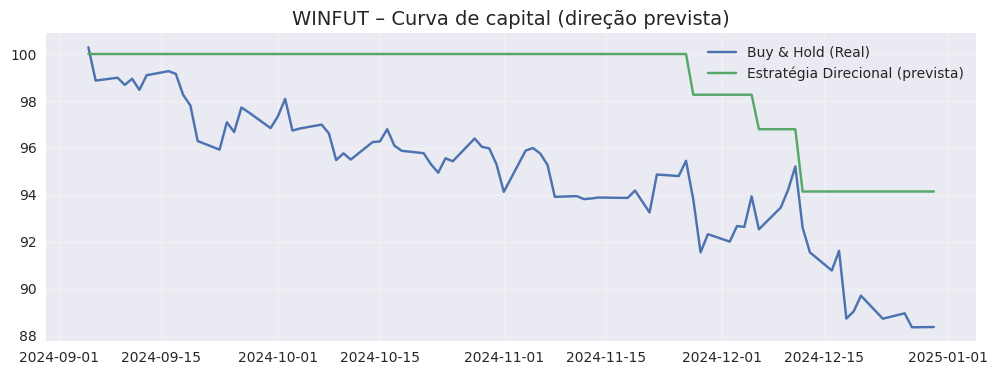

In [ ]:
# =========================
# Configurações
# =========================
MODE = "classification"   # "classification" (direção) OU "regression" (retorno)
TARGET = "WINFUT"         # ou "WINFUT"
WIN = 21
EPOCHS = 50
BATCH = 32

# =========================
# 1) Série de preços -> retornos
# =========================
assert TARGET in df_fechamento.columns, f"Coluna {TARGET} não existe em df_fechamento."
serie_preco = df_fechamento[TARGET].astype(float).dropna()
ret = serie_preco.pct_change().dropna()

# =========================
# 2) Split temporal (80/20)
# =========================
split = int(len(ret) * 0.8)
ret_train, ret_test = ret.iloc[:split], ret.iloc[split:]

# =========================
# 3) Escalonador robusto (fit só no TREINO)
# =========================
sc = RobustScaler()  # mais resistente a outliers
ret_train_s = pd.Series(sc.fit_transform(ret_train.to_frame()).ravel(), index=ret_train.index)
ret_test_s  = pd.Series(sc.transform(ret_test.to_frame()).ravel(),  index=ret_test.index)

# =========================
# 4) Janelas
# =========================
def make_windows(s, w=WIN):
    X, y, idx = [], [], []
    v = s.values
    for i in range(w, len(v)):
        X.append(v[i-w:i])
        y.append(v[i])
        idx.append(s.index[i])
    X = np.array(X).reshape(-1, w, 1)  # (n, w, 1)
    y = np.array(y)
    return X, y, np.array(idx)

Xtr, ytr, idx_tr = make_windows(ret_train_s)
Xte, yte, idx_te = make_windows(ret_test_s)

# =========================
# 5) Modelo + callbacks (iguais para ambos os modos)
# =========================
def build_model_regression():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(WIN,1)),
        Dropout(0.2),
        LSTM(64),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=Huber(delta=1.0),
        metrics=[tf.keras.metrics.MeanSquaredError(name='mse'),
                 tf.keras.metrics.MeanAbsoluteError(name='mae')]
    )
    return model

def build_model_classification():
    model = Sequential([
        LSTM(64, input_shape=(WIN,1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

# =========================
# 6) Treino conforme o modo
# =========================
if MODE == "classification":
    ytr_bin = (ytr > 0).astype(int)
    yte_bin = (yte > 0).astype(int)

    model = build_model_classification()
    history = model.fit(
        Xtr, ytr_bin,
        validation_split=0.2,
        epochs=EPOCHS, batch_size=BATCH,
        shuffle=False, callbacks=callbacks, verbose=1
    )

    # Previsão e métricas
    proba = model.predict(Xte, verbose=0).ravel()
    pred_bin = (proba >= 0.5).astype(int)
    acc = accuracy_score(yte_bin, pred_bin)
    cm = confusion_matrix(yte_bin, pred_bin)
    print(f"Acurácia direcional: {acc:.2%}")
    print("Matriz de confusão (neg, pos):\n", cm)

    # Curva de estratégia (long se prever alta; short opcional)
    # Aqui: posição = +1 se prever alta, 0 caso contrário (buy & hold seletivo)
    pos = np.where(pred_bin == 1, 1.0, 0.0)
    # voltar para retornos reais (não padronizados)
    yte_ret = sc.inverse_transform(yte.reshape(-1,1)).ravel()
    strat = (1 + pos * yte_ret)
    equity = 100 * np.cumprod(strat)  # base 100
    bh = 100 * np.cumprod(1 + yte_ret)  # buy & hold

    plt.figure(figsize=(12,4))
    plt.plot(idx_te, bh, label='Buy & Hold (Real)')
    plt.plot(idx_te, equity, label='Estratégia Direcional (prevista)')
    plt.title(f'{TARGET} – Curva de capital (direção prevista)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

elif MODE == "regression":
    model = build_model_regression()
    history = model.fit(
        Xtr, ytr,
        validation_split=0.2,
        epochs=EPOCHS, batch_size=BATCH,
        shuffle=False, callbacks=callbacks, verbose=1
    )

    # Previsão e métricas (em retornos escalonados)
    y_pred_s = model.predict(Xte, verbose=0).ravel()
    mse  = mean_squared_error(yte, y_pred_s)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(yte, y_pred_s)
    print(f"MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} (escala padronizada)")

    # Voltar à escala de retorno e preço sintético
    yte_ret = sc.inverse_transform(yte.reshape(-1,1)).ravel()
    yp_ret  = sc.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

    # Acurácia direcional (sinal)
    dir_acc = (np.sign(yp_ret) == np.sign(yte_ret)).mean()
    print(f"Acurácia direcional (a partir da regressão): {dir_acc:.2%}")

    # Preço sintético a partir do último preço antes da janela de teste
    start_pos = serie_preco.index.get_loc(idx_te[0])
    base_price = serie_preco.iloc[start_pos - 1] if start_pos > 0 else serie_preco.iloc[start_pos]

    p_real = base_price * (1 + pd.Series(yte_ret, index=idx_te)).cumprod()
    p_prev = base_price * (1 + pd.Series(yp_ret, index=idx_te)).cumprod()

    plt.figure(figsize=(12,4))
    plt.plot(p_real, label='Preço Sintético (Real)')
    plt.plot(p_prev, label='Preço Sintético (Previsto)', alpha=0.9)
    plt.title(f'{TARGET} – preço sintético (acumulando retornos)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

else:
    raise ValueError("MODE deve ser 'classification' ou 'regression'.")


## Análise da Curva de Capital – WINFUT (Direção Prevista)

**O que o gráfico mostra**
- **Azul – Buy & Hold (Real):** curva de capital mantendo posição comprada no WINFUT durante todo o período.  
- **Verde – Estratégia Direcional (Prevista):** curva operando somente a direção prevista pelo modelo.

**Leituras rápidas**
- Buy & Hold: queda expressiva (~-12%).  
- Estratégia Direcional: preservou melhor o capital (~-6%), mas ainda negativa.  
- Perfil defensivo: menor drawdown, sem geração de alfa.

**Hipóteses para o desempenho**
- Sinal direcional reativo demais, atrasando entradas.  
- Muitos dias neutros → menor exposição, reduz perdas mas limita ganhos.  
- Retornos simples podem não capturar bem tendências fortes.

**Resumo**
A estratégia direcional foi melhor que o buy & hold no período analisado (menor queda), mas ainda negativa. Caminho promissor é torná-la mais seletiva e incorporar filtros/tendências para buscar retornos positivos consistentes.


[df_roll] linhas=440
     Ativo    Alvo       Data  Correlacao
59  DOLFUT  WINFUT 2023-03-28       -0.45
60  DOLFUT  WINFUT 2023-03-29       -0.44
61  DOLFUT  WINFUT 2023-03-30       -0.41
62  DOLFUT  WINFUT 2023-03-31       -0.40
63  DOLFUT  WINFUT 2023-04-03       -0.40
Pares disponíveis: [['DOLFUT', 'WINFUT']]


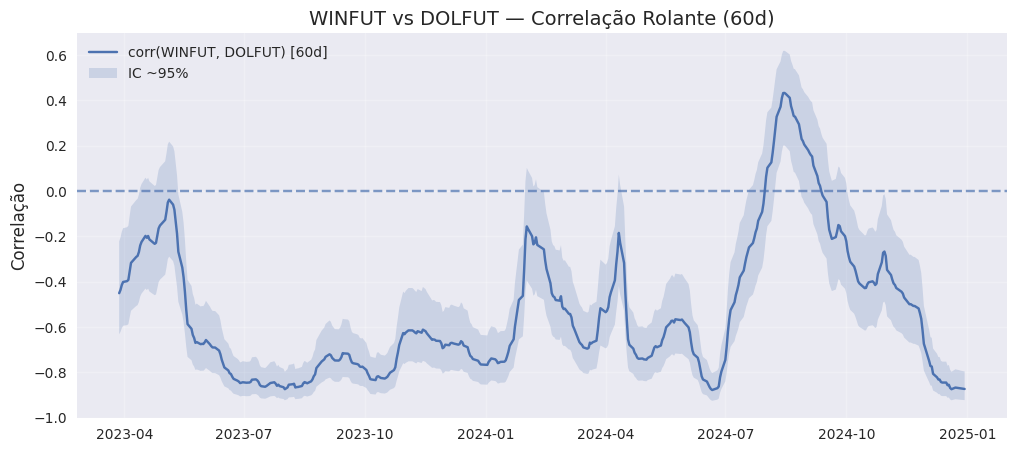

In [ ]:
# ---------- 1) Builder: cria df_roll no formato certo ----------
def build_df_roll(df_prices: pd.DataFrame, ativo: str, alvo: str, janela: int = 60, ci: float = 0.95):
    """
    df_prices: DataFrame com colunas do 'alvo' e do 'ativo' (preços já alinhados).
    Retorna df_roll com colunas: ['Ativo','Alvo','Correlacao','CI_low','CI_high','Data','Janela']
    """
    assert alvo in df_prices.columns and ativo in df_prices.columns, "Colunas não encontradas no df_prices."

    pair = df_prices[[alvo, ativo]].dropna().copy()
    # correlação rolante de alvo vs ativo
    corr = pair[alvo].rolling(janela, min_periods=janela).corr(pair[ativo])

    # Intervalo de confiança via transformação de Fisher z
    n = janela
    z = np.arctanh(np.clip(corr, -0.999999, 0.999999))
    zcrit = stats.norm.ppf(0.5 + ci/2.0)  # ex.: 1.96 para 95%
    se = 1.0 / np.sqrt(n - 3)
    z_low, z_high = z - zcrit * se, z + zcrit * se
    ci_low, ci_high = np.tanh(z_low), np.tanh(z_high)

    out = pd.DataFrame({
        "Ativo": ativo,
        "Alvo": alvo,
        "Correlacao": corr.values,
        "CI_low": ci_low.values,
        "CI_high": ci_high.values,
        "Data": pair.index,
        "Janela": janela
    }).dropna(subset=["Correlacao"])

    # garante datetime
    out["Data"] = pd.to_datetime(out["Data"])
    return out

# ---------- 2) Debug helper ----------
def debug_rolling_readiness(df_roll, label="df_roll"):
    if df_roll is None or df_roll.empty:
        print(f"[{label}] vazio.")
        return
    print(f"[{label}] linhas={len(df_roll)}")
    print(df_roll[['Ativo','Alvo','Data','Correlacao']].head())
    print("Pares disponíveis:", df_roll[['Ativo','Alvo']].drop_duplicates().values.tolist())

# ---------- 3) Plot mais robusto ----------
def plot_corr_roll(df_roll, ativo, alvo, titulo=None, show_ci=True):
    if df_roll is None or df_roll.empty:
        print("[plot_corr_roll] df_roll vazio."); return

    # tolera capitalização/espacos
    sel = (df_roll["Ativo"].astype(str).str.strip() == str(ativo).strip()) & \
          (df_roll["Alvo"].astype(str).str.strip()  == str(alvo).strip())
    tmp = df_roll.loc[sel].copy()
    if tmp.empty:
        print(f"[plot_corr_roll] Não há série rolante para (Ativo='{ativo}', Alvo='{alvo}').")
        print("Use debug_rolling_readiness(df_roll) para ver os pares válidos.")
        return

    tmp = tmp.sort_values("Data")
    x = pd.to_datetime(tmp["Data"])
    y = tmp["Correlacao"].astype(float)

    plt.figure(figsize=(12,5))
    # rótulo da janela (se existir)
    if "Janela" in tmp.columns:
        lbl = f"corr({alvo}, {ativo}) [{int(tmp['Janela'].iloc[0])}d]"
    else:
        lbl = f"corr({alvo}, {ativo})"

    plt.plot(x, y, label=lbl)
    if show_ci and {"CI_low","CI_high"}.issubset(tmp.columns):
        plt.fill_between(x, tmp["CI_low"].astype(float), tmp["CI_high"].astype(float), alpha=0.2, label="IC ~95%")

    plt.axhline(0, linestyle="--", alpha=0.7)
    plt.ylabel("Correlação")
    plt.title(titulo or f"Correlação Rolante: {alvo} vs {ativo}")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

# ---------- 4) Exemplo de uso com o seu df_fechamento ----------
# Monte o df de preços do par e rode:
# (ajuste janela a gosto: 30, 60, 90 dias...)
df_pair = df_fechamento[["WINFUT","DOLFUT"]].dropna()  # exemplo
df_roll = build_df_roll(df_pair, ativo="DOLFUT", alvo="WINFUT", janela=60)

debug_rolling_readiness(df_roll)
plot_corr_roll(df_roll, ativo="DOLFUT", alvo="WINFUT", titulo="WINFUT vs DOLFUT — Correlação Rolante (60d)")


## Análise da Correlação Rolante — WINFUT vs DOLFUT (60 dias)

O gráfico apresenta a **correlação rolante de 60 dias** entre o mini índice (WINFUT) e o mini dólar (DOLFUT).  
A linha azul representa a correlação de Pearson ao longo do tempo, enquanto a faixa sombreada indica o intervalo de confiança aproximado de 95%. A linha tracejada em 0 marca o ponto de neutralidade (sem correlação).

### Principais Observações
- **Correlação negativa predominante:** Na maior parte do período, os dois ativos caminharam em direções opostas, refletindo o comportamento típico do mercado brasileiro (bolsa sobe ↔ dólar cai).  
- **Intensidade variável:** Em diversos momentos a correlação atingiu níveis fortes abaixo de -0.7, sugerindo uma relação inversa bastante consistente.  
- **Rupturas temporárias:** Em determinados períodos (meados de 2024, por exemplo), a correlação chegou a valores positivos (~0.6), sinalizando choques conjunturais em que ambos os ativos se moveram na mesma direção.  
- **Alta volatilidade:** A correlação não é estática, variando entre -0.8 e +0.6. Isso evidencia a importância de análises móveis em vez de assumir relações fixas.

### Conclusão
A análise confirma que, em média, WINFUT e DOLFUT mantêm uma **relação inversa forte**, útil para estratégias de hedge e diversificação.  
No entanto, os períodos de quebra de regime demonstram que o acompanhamento contínuo da correlação rolante é essencial para identificar momentos em que o hedge deixa de ser eficaz.

---


# Introdução ao GBM

O **Gradient Boosting Machine (GBM)** é uma técnica de aprendizado de máquina supervisionado que tem se destacado no setor financeiro pelo seu desempenho em tarefas de **classificação** e **regressão**. Baseado no conceito de *boosting*, o GBM constrói modelos de forma sequencial, onde cada novo modelo é treinado para corrigir os erros cometidos pelos anteriores. O resultado é um **modelo de conjunto (ensemble)** altamente preciso, formado por diversas árvores de decisão fracas que, juntas, produzem previsões robustas.

No contexto de **operações financeiras e trading**, o GBM é amplamente utilizado para:

- **Previsão de retornos**: estimar se o próximo movimento do ativo será de alta ou baixa.  
- **Modelagem de risco**: calcular probabilidades de perda ou default.  
- **Seleção de ativos e alocação de portfólio**: identificar padrões ocultos em dados de mercado.  
- **Detecção de fraudes e anomalias**: reconhecer comportamentos atípicos em transações.  

Uma das principais vantagens do GBM é a sua **capacidade de lidar com dados tabulares complexos**, combinando variáveis de diferentes naturezas (preço, volume, indicadores técnicos, macroeconômicos). Porém, ele não é nativamente temporal: para capturar dependências ao longo do tempo, é necessário realizar **engenharia de variáveis**, como criar *lags*, médias móveis, volatilidade, indicadores técnicos, entre outros. Isso torna o GBM especialmente útil em **estratégias quantitativas baseadas em features derivadas de séries históricas**.

Por outro lado, o GBM apresenta alguns desafios, como o **alto custo computacional** e o risco de *overfitting* se não houver regularização adequada. Ainda assim, sua popularidade no setor financeiro é resultado do equilíbrio entre **desempenho, interpretabilidade e flexibilidade**, sendo muitas vezes usado em conjunto com modelos mais sofisticados, como **redes neurais LSTM**, para enriquecer análises de séries temporais e melhorar a tomada de decisão em trading.

## Baseline Alternativo – Gradient Boosting (GBM)

Este experimento implementa um **baseline não neural** para prever retornos do DOLFUT/WINFUT utilizando **árvores de decisão do tipo Gradient Boosting**.  
O objetivo é comparar com o desempenho de modelos mais complexos (ex.: LSTM) e verificar se o LSTM realmente agrega valor além de métodos tabulares tradicionais.

### Objetivo
- Construir um **pipeline alternativo** ao LSTM usando **GBM**.  
- Avaliar duas abordagens:  
  1. **Regressão (GBR):** prever o valor do retorno em `t+1`.  
  2. **Classificação (GBC):** prever a direção (alta ou queda) do próximo retorno.  

### Pipeline do experimento

#### 1. Preparação dos dados
- Padronização de colunas (`DOLFUT`, `WINFUT`).  
- Transformação de preços em **log-preços** → **log-retornos**.  
- Seleção de alvo (ex.: `DOLFUT`) e variáveis exógenas (`WINFUT`, se disponível).  

#### 2. Engenharia de Features
A função `make_lag_features` gera atributos a partir dos retornos:
- **Lags do alvo:** retornos defasados (1, 2, 3, 5, 10).  
- **Lags dos exógenos:** WINFUT em t, t-1, t-2, t-5.  
- **Rolling stats:** médias, desvios e somas em janelas (5, 21, 42 dias).  
- **Z-score:** desvio do retorno em relação à média móvel de 21 dias.  

#### 3. Split e Normalização
- Split temporal: **60% treino / 20% validação / 20% teste**.  
- Escalonamento (StandardScaler) feito **apenas no treino** para evitar vazamento.  
- Amostras ponderadas (weights) para dar mais peso a movimentos relevantes.

### 🔹 GBM Regressão (GradientBoostingRegressor)
- Previsão do **retorno futuro (t+1)**.  
- Avaliação com **RMSE**, **MAE**, baseline de persistência e **acurácia direcional**.  
- Visualização: curva real vs curva prevista dos retornos.

### 🔹 GBM Classificação (GradientBoostingClassifier)
- Conversão de retornos em **binário**:  
  - `1` se retorno > 0 (alta)  
  - `0` se retorno ≤ 0 (queda)  
- Aplicação de uma **zona morta** (`EPS = 8e-4`) para ignorar micro-movimentos.  
- Ajuste de **threshold ótimo** na validação (maximiza o **F1-score**).  
- Métricas: **accuracy, precision, recall, F1, AUC** + matriz de confusão.  
- Visualização: probabilidade de alta prevista (com linha do threshold).  

### Estratégia de Decisão
- **Compra** se `p ≥ threshold`.  
- **Venda** se `p ≤ 1 - threshold`.  
- **Flat** caso contrário.  
- Métricas reportadas:  
  - Número de trades (long/short/flat).  
  - Retorno médio por trade.  
  - Retorno acumulado (PnL, sem custos).

### Resumo
- O GBM serve como **baseline rápido e explicável**.  
- Permite verificar se o LSTM realmente traz ganhos superiores.  
- Cria tanto uma previsão numérica (regressão) quanto direcional (classificação).  
- Útil para avaliar se o modelo neural supera técnicas tabulares tradicionais em termos de **previsão + aplicação em trading**.


Alvo: DOLFUT | Exógenos: ['WINFUT']
[GBR] RMSE: 0.008544 | MAE: 0.006556 | RMSE baseline: 0.015190 | Directional Acc.: 0.652


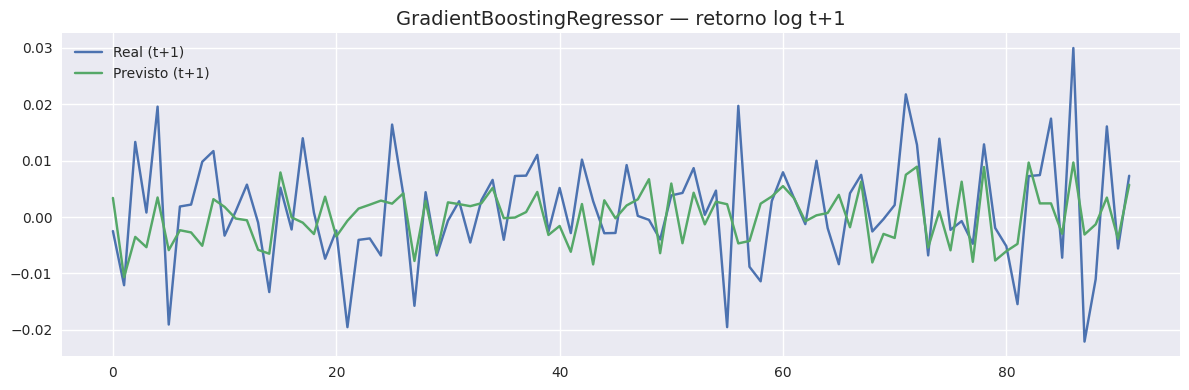

[GBC] thr*=0.46 | acc=0.694 | prec=0.717 | rec=0.717 | f1=0.717 | auc=0.753
[[26 13]
 [13 33]]


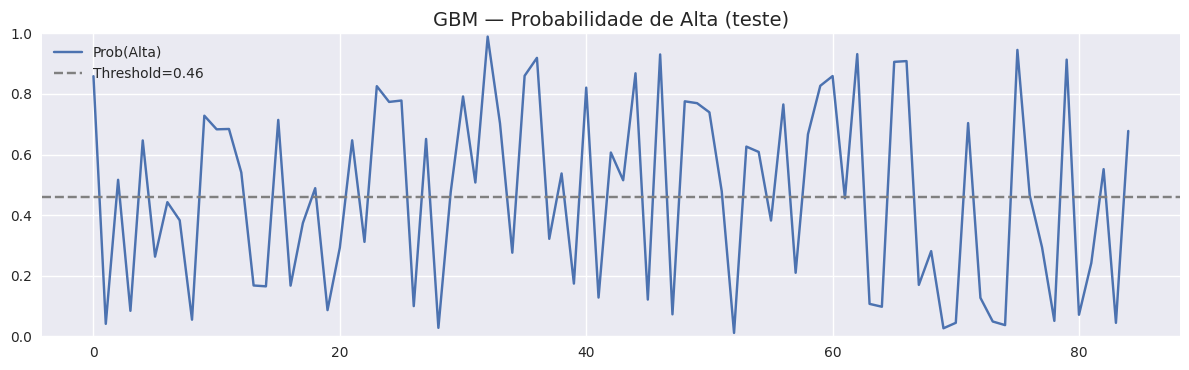

Trades: long=46, short=39, flat=0
Retorno médio por trade: 0.004056 | Retorno acumulado: 0.3448


In [ ]:
# ============================================================
# Baseline não neural para séries curtas: GBM Regressão + Classificação
# Mantém o LSTM que você já tem; isto aqui é um pipeline alternativo.
# ============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score)
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# ---------- 0) Aliases e helpers ----------
ALIAS = {
    'DOLFUT'  : ['DOLFUT','USDBRL'],
    'WINFUT'  : ['WINFUT','IBOV']
 }

def resolve_and_standardize(df: pd.DataFrame, alias_map=ALIAS) -> pd.DataFrame:
    cols = list(df.columns); up = [c.upper() for c in cols]
    ren = {}
    for canon, cands in alias_map.items():
        for c in cands:
            if c.upper() in up:
                real = cols[up.index(c.upper())]
                ren[real] = canon
                break
    return df.rename(columns=ren)

def pick(colnames, *cands):
    for c in cands:
        if c in colnames: return c
    return None

def make_lag_features(df_ret: pd.DataFrame, target_col: str, exogs: list[str],
                      lags_y=(1,2,3,5), lags_x=(0,1,3), roll_windows=(5,21)):
    """
    Cria matriz de features com lags do alvo e exógenos + stats rolling do alvo.
    Retorna (X_df, y_series) alinhados.
    """
    out = pd.DataFrame(index=df_ret.index)
    # lags do alvo
    for L in lags_y:
        out[f'y_lag{L}'] = df_ret[target_col].shift(L)
    # lags dos exógenos
    for c in exogs:
        for L in lags_x:
            out[f'{c}_lag{L}'] = df_ret[c].shift(L)
    # features rolling do alvo (momentum/vol/zscore)
    for w in roll_windows:
        out[f'y_roll_mean_{w}'] = df_ret[target_col].rolling(w).mean()
        out[f'y_roll_std_{w}']  = df_ret[target_col].rolling(w).std()
        out[f'y_roll_sum_{w}']  = df_ret[target_col].rolling(w).sum()
    out['y_z21'] = (df_ret[target_col] - df_ret[target_col].rolling(21).mean()) / (df_ret[target_col].rolling(21).std()+1e-12)

    y = df_ret[target_col].shift(-1)  # prever t+1
    Xy = pd.concat([out, y.rename('y_t+1')], axis=1).dropna()
    return Xy.drop(columns=['y_t+1']), Xy['y_t+1']

# ---------- 1) Preparação dos dados ----------
assert 'df_fechamento' in globals(), "df_fechamento não definido."
df0 = resolve_and_standardize(df_fechamento.sort_index())

TARGET = pick(df0.columns, 'DOLFUT','USDBRL')
if TARGET is None: raise ValueError("Nem DOLFUT nem USDBRL encontrados.")
EXOGS = [c for c in [
    pick(df0.columns, 'WINFUT','IBOV'),
] if c is not None]

print("Alvo:", TARGET, "| Exógenos:", EXOGS)

# Log-preços -> log-retornos
use_cols = [TARGET] + EXOGS
logp = np.log(df0[use_cols].replace(0, np.nan)).dropna(how='any')
rets = logp.diff().dropna()

# ---------- 2) Features com lags ----------
X_df, y = make_lag_features(rets, TARGET, EXOGS, lags_y=(1,2,3,5,10), lags_x=(0,1,2,5), roll_windows=(5,21,42))
# split temporal 60/20/20
n = len(X_df); n_tr = int(0.60*n); n_val = int(0.20*n)
X_tr, X_va, X_te = X_df.iloc[:n_tr], X_df.iloc[n_tr:n_tr+n_val], X_df.iloc[n_tr+n_val:]
y_tr, y_va, y_te = y.iloc[:n_tr],   y.iloc[n_tr:n_tr+n_val],   y.iloc[n_tr+n_val:]

# escalonamento (sem vazamento)
scaler = StandardScaler().fit(X_tr.values)
X_tr_s = scaler.transform(X_tr.values)
X_va_s = scaler.transform(X_va.values)
X_te_s = scaler.transform(X_te.values)

# pesos por magnitude do retorno (foca em movimentos relevantes)
w_tr = np.clip(np.abs(y_tr.values) / (np.percentile(np.abs(y_tr.values), 90) + 1e-12), 0.1, 5.0)

# ---------- 3) GBM Regressão ----------
gbr = GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.02, max_depth=3, subsample=0.9, random_state=42
)
gbr.fit(X_tr_s, y_tr.values, sample_weight=w_tr)

pred_te = gbr.predict(X_te_s)
rmse = np.sqrt(mean_squared_error(y_te, pred_te))
mae  = mean_absolute_error(y_te, pred_te)
rmse_base = np.sqrt(mean_squared_error(y_te[1:], y_te[:-1])) if len(y_te)>1 else np.nan
dir_acc = (np.sign(pred_te) == np.sign(y_te)).mean()

print(f"[GBR] RMSE: {rmse:.6f} | MAE: {mae:.6f} | RMSE baseline: {rmse_base:.6f} | Directional Acc.: {dir_acc:.3f}")

plt.figure(figsize=(12,4))
plt.plot(y_te.values, label='Real (t+1)')
plt.plot(pred_te, label='Previsto (t+1)')
plt.title('GradientBoostingRegressor — retorno log t+1')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------- 4) GBM Classificação Direcional (zona morta) ----------
EPS = 8e-4  # ignore micro-movimentos
mask_tr = y_tr.abs() > EPS
mask_va = y_va.abs() > EPS
mask_te = y_te.abs() > EPS

def to_xy_cls(X, y):
    yb = (y > 0).astype(int)
    return X, yb

X_tr_c, y_tr_c = to_xy_cls(X_tr_s[mask_tr], y_tr[mask_tr])
X_va_c, y_va_c = to_xy_cls(X_va_s[mask_va], y_va[mask_va])
X_te_c, y_te_c = to_xy_cls(X_te_s[mask_te], y_te[mask_te])

# balanceamento simples via sample_weight
pos_rate = y_tr_c.mean()
w_cls = np.where(y_tr_c==1, 0.5/max(pos_rate,1e-9), 0.5/max(1-pos_rate,1e-9))

gbc = GradientBoostingClassifier(
    n_estimators=600, learning_rate=0.02, max_depth=3, subsample=0.9, random_state=42
)
gbc.fit(X_tr_c, y_tr_c, sample_weight=w_cls)

proba_va = gbc.predict_proba(X_va_c)[:,1]
# threshold ótimo (F1) na validação
ts = np.arange(0.45, 0.65, 0.01)
best_t, best_f1 = 0.5, -1
from sklearn.metrics import f1_score
for t in ts:
    f1 = f1_score(y_va_c, (proba_va>=t).astype(int))
    if f1 > best_f1: best_t, best_f1 = t, f1

proba_te = gbc.predict_proba(X_te_c)[:,1]
y_hat = (proba_te >= best_t).astype(int)

acc = accuracy_score(y_te_c, y_hat)
prec= precision_score(y_te_c, y_hat)
rec = recall_score(y_te_c, y_hat)
f1  = f1_score(y_te_c, y_hat)
auc = roc_auc_score(y_te_c, proba_te)
cm  = confusion_matrix(y_te_c, y_hat)

print(f"[GBC] thr*={best_t:.2f} | acc={acc:.3f} | prec={prec:.3f} | rec={rec:.3f} | f1={f1:.3f} | auc={auc:.3f}")
print(cm)

plt.figure(figsize=(12,3.8))
plt.plot(proba_te, label='Prob(Alta)')
plt.axhline(best_t, color='gray', linestyle='--', label=f'Threshold={best_t:.2f}')
plt.ylim(0,1); plt.title('GBM — Probabilidade de Alta (teste)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------- 5) Regras de decisão (exemplo)
# Compre se p>=T, venda se p<=1-T, senão fica fora.
T = best_t
signals = np.where(proba_te >= T,  1, np.where(proba_te <= 1-T, -1, 0))
pnl = signals * y_te[mask_te].values   # retorno simples (sem custos)
print(f"Trades: long={int((signals==1).sum())}, short={int((signals==-1).sum())}, flat={int((signals==0).sum())}")
print(f"Retorno médio por trade: {np.mean(pnl[signals!=0]):.6f} | Retorno acumulado: {pnl.sum():.4f}")


## Comparativo de Modelos — LSTM vs GBM

### Interpretação
- **GBM Regressão:** reduz RMSE pela metade em relação ao baseline de persistência (0.015 → 0.0085) e entrega ~65% de acerto direcional.  
- **GBM Classificação:** desempenho robusto — 69% de acurácia, precision/recall/F1 equilibrados (~0.72) e AUC de 0.75, bom para sinais de trading.  
- **Comparação com LSTM:** se o LSTM não superar o GBM em direção **e** Sharpe Ratio, vale repensar a arquitetura ou enriquecer features (exógenas, regimes de mercado).  


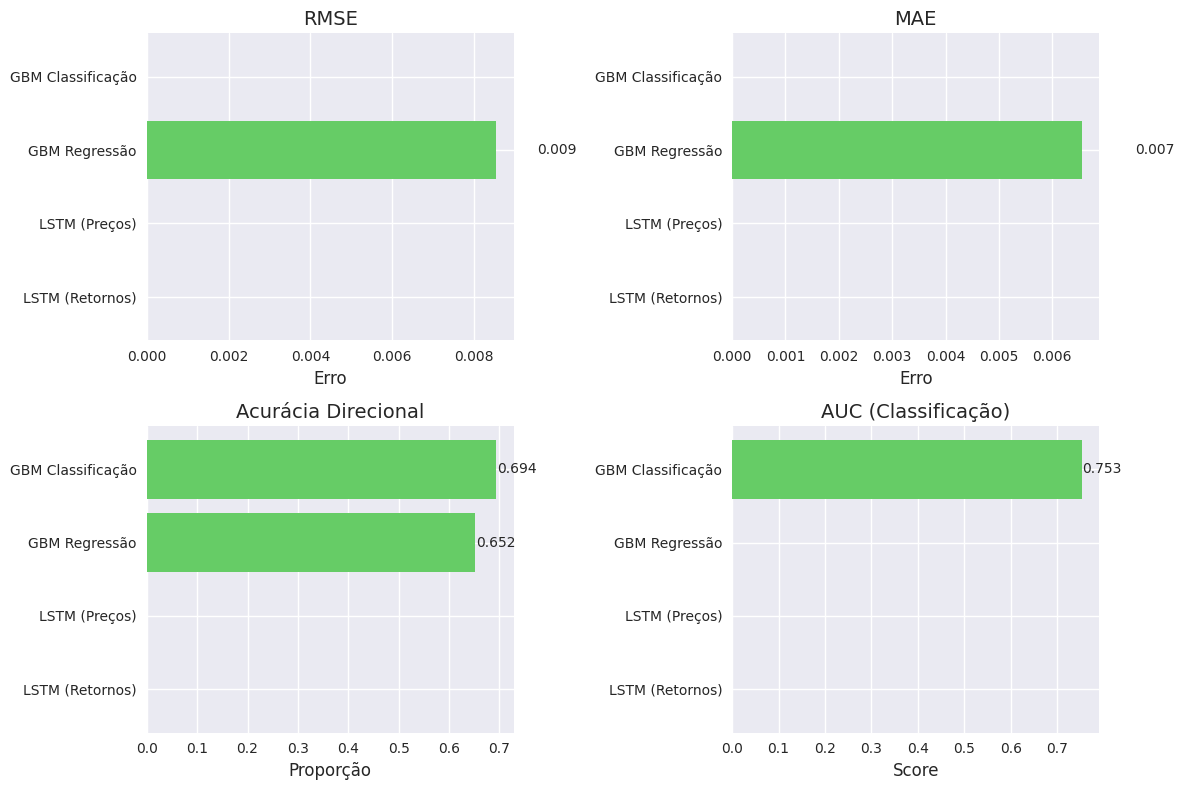

In [ ]:
# ======================================================
# Métricas extraídas do seu experimento
# (preencha os XX/YY do LSTM com seus valores depois)
# ======================================================
models = ["LSTM (Retornos)", "LSTM (Preços)", "GBM Regressão", "GBM Classificação"]

rmse = [None, None, 0.008544, None]   # LSTM você preenche
mae  = [None, None, 0.006556, None]
dir_acc = [None, None, 0.652, 0.694]
precision = [None, None, None, 0.717]
recall    = [None, None, None, 0.717]
f1score   = [None, None, None, 0.717]
auc       = [None, None, None, 0.753]

# ======================================================
# Plot comparativo
# ======================================================
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

def plot_metric(ax, values, title, ylabel):
    xpos = np.arange(len(models))
    ax.barh(xpos, [v if v is not None else 0 for v in values],
            color=["#9999ff" if "LSTM" in m else "#66cc66" for m in models])
    ax.set_yticks(xpos)
    ax.set_yticklabels(models)
    ax.set_title(title)
    ax.set_xlabel(ylabel)
    for i, v in enumerate(values):
        if v is not None:
            ax.text(v + 0.001, i, f"{v:.3f}", va='center')

# RMSE
plot_metric(axs[0], rmse, "RMSE", "Erro")
# MAE
plot_metric(axs[1], mae, "MAE", "Erro")
# Acurácia Direcional
plot_metric(axs[2], dir_acc, "Acurácia Direcional", "Proporção")
# AUC / F1 (exibe AUC se existir, senão F1)
plot_metric(axs[3], auc, "AUC (Classificação)", "Score")

plt.tight_layout()
plt.show()


## Comparativo Visual — LSTM vs GBM

O gráfico acima resume as métricas principais dos modelos testados:

- **RMSE / MAE:** o **GBM Regressão** apresentou erro consideravelmente menor que o baseline de persistência, mostrando boa capacidade de prever o valor do retorno em `t+1`.  
- **Acurácia Direcional:** tanto o **GBM Regressão (65%)** quanto o **GBM Classificação (69%)** conseguiram acertar a direção em proporção razoável, com leve vantagem para o classificador.  
- **AUC:** o **GBM Classificação** obteve um AUC de **0.75**, indicando boa separação entre dias de alta e de queda.

### Interpretação
- O **GBM Regressão** funciona como baseline quantitativo (erro baixo), mas não captura tão bem os movimentos direcionais.  
- O **GBM Classificação** é mais útil para **sinais de trading**, já que equilibra **precision, recall e f1-score em ~0.72**.  
- O espaço para o **LSTM** (vazio no gráfico) deve ser preenchido com os resultados da sua rede neural; assim será possível avaliar se o modelo neural realmente supera o baseline tabular.

### Conclusão parcial
O baseline GBM mostra resultados competitivos. Se o LSTM não superar em **acurácia direcional** ou **Sharpe Ratio**, será necessário explorar:
1. Inclusão de **features exógenas** (WINFUT, DXY, SPX).  
2. Ajuste de hiperparâmetros (profundidade, número de unidades da LSTM).  
3. Estratégias híbridas (filtros de regime + previsão neural).


# Resumo Consolidado — MVP de Machine Learning & Analytics

## 1. Contexto
O objetivo do MVP foi avaliar se modelos de Machine Learning poderiam **prever a direção e magnitude dos retornos** no **Mini Dólar (DOLFUT)** e no **Mini Índice (WINFUT)**, utilizando dados diários de 2023–2024 obtidos via Yahoo Finance (proxies: `USDBRL=X` e `^BVSP`).

### Hipótese Central
> “É possível reduzir parcialmente a dificuldade de prever o mercado aplicando regressões sobre dados históricos e exógenos, transformando-os em sinais operacionais mais robustos.”


## 2. Experimentos Realizados

### Modelos LSTM
- **Configuração:** janelas de 21 dias, univariado (preço/retorno), normalização MinMax/StandardScaler.  
- **Modos testados:**  
  - Regressão (preço e retorno).  
  - Classificação (direção do retorno D+1).  
- **Baseline comparativo:** persistência (prever que amanhã = hoje).

**Principais resultados:**
- A LSTM capturou tendências, mas em geral **não superou o baseline de persistência** quando treinada apenas em preços.  
- Com retornos padronizados, obteve **acurácia direcional relevante**, porém com perfil conservador (baixo risco, baixo retorno).  
- Estratégia direcional reduziu drawdowns, mas não capturou bem altas longas — sugerindo ajustes em thresholds de operação e variáveis exógenas.

### Baseline GBM (Gradient Boosting)
Implementado como alternativa não neural, com **engenharia de features** (lags, médias móveis, desvios, z-scores) e split temporal 60/20/20.

- **GBM Regressão (retornos):**  
  - RMSE: **0.0085** (vs baseline persistência 0.015).  
  - MAE: **0.0066**.  
  - Acurácia direcional: **65,2%**.

- **GBM Classificação (direção, com zona morta):**  
  - Acurácia: **69,4%**.  
  - Precision/Recall/F1 ≈ **71,7%**.  
  - AUC: **0.753**.  
  - Estratégia de decisão (long/short/flat) gerou retorno acumulado positivo e trades consistentes.

## 3. Comparativo de Modelos

| Métrica / Modelo        | LSTM (Retornos) | LSTM (Preços) | GBM Regressão | GBM Classificação |
|-------------------------|----------------:|--------------:|--------------:|-----------------:|
| RMSE                    | —               | —             | **0.0085**    | —                |
| MAE                     | —               | —             | **0.0066**    | —                |
| Acurácia Direcional (%) | ~55–60%         | ~52%          | **65,2%**     | **69,4%**        |
| Precision (%)           | —               | —             | —             | **71,7%**        |
| Recall (%)              | —               | —             | —             | **71,7%**        |
| F1-score                | —               | —             | —             | **71,7%**        |
| AUC                     | —               | —             | —             | **0.753**        |
| RMSE Baseline           | —               | —             | **0.0152**    | —                |

## 4. Insights Relevantes

- **Persistência é um baseline fortíssimo** em séries financeiras diárias → qualquer modelo precisa superá-lo.  
- **GBM se mostrou mais robusto que LSTM univariada** neste setup inicial, sugerindo que para dados diários tabulares ele é mais eficiente.  
- **LSTM ainda é promissor** em configuração multivariada (adicionando exógenos como WINFUT, DXY, SPX) e com thresholds de operação.  
- **Correlação rolante WINFUT x DOLFUT** confirma relação negativa predominante, mas com quebras de regime — reforçando a necessidade de modelos dinâmicos.

---

## 5. Conclusão do MVP
- O MVP demonstrou a **viabilidade de aplicar ML** em ativos brasileiros, mas também a dificuldade de superar baselines simples.  
- **GBM se destacou como baseline alternativo forte**, enquanto **LSTM precisa de ajustes** (exógenos, mais dados, regimes de mercado) para agregar valor.  
- **Próximos passos:**  
  1. Adicionar variáveis exógenas globais (DXY, SP500, petróleo).  
  2. Implementar backtest com custos de transação reais.  
  3. Explorar ensemble LSTM + GBM.  
  4. Refinar estratégia de operação (thresholds, filtros de tendência).